In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


import seaborn as sns
'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 





In [46]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [47]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/cnn_kernel_check_dual/")
SAVE_DIR = os.path.join(CODE_DIR, "simple_cnn_models_dual/")

In [48]:

# Check if the directory exists
if not os.path.exists(FIG_DIR):
    # Create the directory
    os.makedirs(FIG_DIR)
    print(f"Directory '{FIG_DIR}' was created.")
else:
    print(f"Directory '{FIG_DIR}' already exists.")



if not os.path.exists(SAVE_DIR):
    # Create the directory
    os.makedirs(SAVE_DIR)
    print(f"Directory '{SAVE_DIR}' was created.")
else:
    print(f"Directory '{SAVE_DIR}' already exists.")

Directory '/home/jenny/evidence-chain/figs/cnn_kernel_check_dual/' already exists.
Directory '/home/jenny/evidence-chain/simple_cnn_models_dual/' already exists.


In [49]:
stimdur = '250'
pos = 10
evaluate_mode = False

In [50]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_36615/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_36615/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_36615/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [51]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [52]:
df.shape

(3400, 13)

In [53]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ...",9
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...",7
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ...",7
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...",4
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0...",8


In [54]:
count.max()

29

In [55]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [56]:
# fig, ax = plot_performance_matrix(performance_matrix_test)

In [57]:
dataset, dataset_resp = make_dataset(pos, count, chain_matrix)
x_train, x_test, y_train, y_test = train_test_split(
    dataset, dataset_resp, test_size=0.3, random_state=2024
)
x_train, x_val, y_train, y_val = train_test_split(
x_train, y_train, test_size=0.25, random_state=1
)

In [58]:
x_train.shape

(521, 11)

In [59]:
# x_train = get_evidence(x_train)
# x_val = get_evidence(x_val)
# x_test = get_evidence(x_test)

In [60]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert numpy arrays to PyTorch tensors and create datasets
def create_dataset(x, y):
    x_tensor = torch.Tensor(x).unsqueeze(1)  # Add channel dimension
    y_tensor = torch.Tensor(y).unsqueeze(1)
    y_tensor = y_tensor.type(torch.float32)  # Convert boolean labels to float for BCELoss
    return TensorDataset(x_tensor, y_tensor)

# Create datasets
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)
test_dataset = create_dataset(x_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



x_train.shape

In [61]:

# Define the model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=4, stride=1, padding=0)  # output is N x 16 x 5
        self.fc1 = nn.Linear(2, 1,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        # x = torch.relu(x)
        x, max_ind= torch.max(x[:,:,-2:], 2)  # Global average pooling
        # print(max_ind)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [62]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # model.fc1.apply(clipper)
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()  # add loss 
            all_outputs.extend(outputs.squeeze().cpu().numpy())
            all_targets.extend(targets.squeeze().cpu().numpy())
    return total_loss / len(dataloader), all_outputs, all_targets

In [66]:
evaluate_mode

False

In [67]:

if evaluate_mode:
    PATH = f'/home/jenny/evidence-chain/simple_cnn_models_dual/best_pos{pos}_running,pkl'
    model =CNN1D()
    model.load_state_dict(torch.load(PATH))
    model.eval()
    model = model.to(device)


    # Loss function and optimizer
    criterion = nn.BCELoss()


    # Train the model
    num_epochs = 20
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss,_,_ = evaluate(model, train_loader, criterion)
        val_loss, _, _ = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # if epoch % 10 ==0:
        #     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # Evaluate AUC on the test set
    test_loss, test_outputs, test_targets = evaluate(model, test_loader, criterion)
    train_loss, train_outputs, train_targets = evaluate(model, train_loader, criterion)

    test_auc = roc_auc_score(test_targets, test_outputs)
    train_auc = roc_auc_score(train_targets, train_outputs)


    print(f'Train Loss: {train_loss}')
    print(f'Train AUC: {train_auc}')



    test_auc = roc_auc_score(test_targets, test_outputs)
    print(f'Test Loss: {test_loss}')
    print(f'Test AUC: {test_auc}')



In [65]:
if not evaluate_mode:
    best_test_auc = 0
    best_train_auc = 0
    for i in range(300):
        model = CNN1D().to(device)
        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = Adam(model.parameters(), lr=0.001)


        # Train the model
        num_epochs = 300
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            val_loss, _, _ = evaluate(model, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # if epoch % 10 ==0:
            #     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')



        # Evaluate AUC on the test set
        test_loss, test_outputs, test_targets = evaluate(model, test_loader, criterion)
        train_loss, train_outputs, train_targets = evaluate(model, train_loader, criterion)

        test_auc = roc_auc_score(test_targets, test_outputs)
        train_auc = roc_auc_score(train_targets, train_outputs)

        print(f"===================ATTEMP {i}======================")

        print(f'Train Loss: {train_loss}')
        print(f'Train AUC: {train_auc}')



        test_auc = roc_auc_score(test_targets, test_outputs)
        print(f'Test Loss: {test_loss}')
        print(f'Test AUC: {test_auc}')

        if test_auc >best_test_auc and train_auc>best_train_auc:
            best_test_auc = test_auc
            best_train_auc = train_auc
            PATH = f'/home/jenny/evidence-chain/simple_cnn_models_dual/best_pos{pos}_running.pkl'
            torch.save(model.state_dict(), PATH)
            print("saved a better model!\n")

                # # Plot training and validation losses
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            plt.show()


===================ATTEMP 0======================
Train Loss: 0.3140203286619747
Train AUC: 0.6010522496371553
Test Loss: 0.3269743025302887
Test AUC: 0.5171136653895274
saved a better model!
===================ATTEMP 1======================
Train Loss: 0.2972259793211432
Train AUC: 0.7092404450895018
Test Loss: 0.3298609897494316
Test AUC: 0.6199233716475094
saved a better model!
===================ATTEMP 2======================
Train Loss: 0.32547678666956287
Train AUC: 0.5827084341235285
Test Loss: 0.3291509494185448
Test AUC: 0.5314814814814816
===================ATTEMP 3======================
Train Loss: 0.29891961856799965
Train AUC: 0.6921262699564588
Test Loss: 0.3271974936127663
Test AUC: 0.6220306513409963
===================ATTEMP 4======================
Train Loss: 0.3167889854487251
Train AUC: 0.564687147234317
Test Loss: 0.3282929539680481
Test AUC: 0.6211366538952746
===================ATTEMP 5======================
Train Loss: 0.3176102752194685
Train AUC: 0.63175294307

In [68]:
model.fc1.weight.data

tensor([[ 1.1374, -1.1676]], device='cuda:0')

In [69]:
conv_bias = model.conv1.bias.data

In [70]:
conv_bias

tensor([-1.0607,  0.6534], device='cuda:0')

In [71]:
weights = model.conv1.weight.data

In [72]:
weights

tensor([[[ 0.4197, -0.2688,  0.1959, -0.0227]],

        [[ 0.5610, -0.4165,  0.2818, -0.2118]]], device='cuda:0')

In [73]:
fc_weights = model.fc1.weight.data

In [74]:
fc_weights

tensor([[ 1.1374, -1.1676]], device='cuda:0')

[ 0.41965985 -0.26880524  0.19585745 -0.02267043]


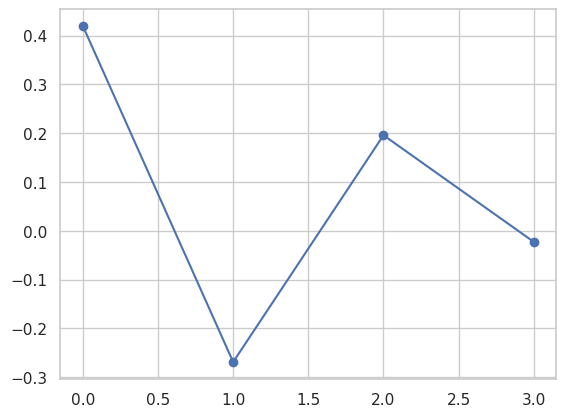

[ 0.5610368  -0.41645503  0.2817501  -0.21177725]


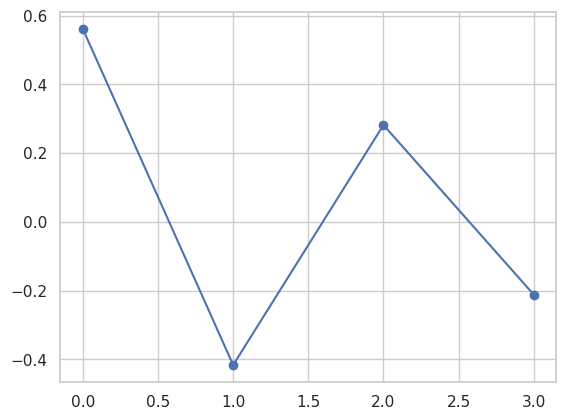

In [75]:
for w in weights:
    w = w.cpu().numpy().squeeze()
    print(w)
    plt.plot(np.arange(0,4),w,'o-')
    plt.show()

In [76]:
# weights_list = []


In [77]:
kernel = weights.cpu().numpy()
position = pos
fc_bias = fc_weights.cpu().numpy()
conv_bias = conv_bias.cpu().numpy()

In [78]:
mydict = {}
mykeys = ["kernel", "position","fc_bias", "conv_bias"]
values = [kernel, position, fc_bias, conv_bias]
for key, value in zip(mykeys, values):
    # Here you can add conditions or transformations
    mydict[key] = value

In [79]:
import pickle
# Save the dictionary into a pickle file
FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param.pkl")
with open(FILEPATH, 'wb') as pickle_file:
    pickle.dump(mydict, pickle_file)

In [ ]:
m = nn.Conv1d(1, 1, 3, stride=2,bias=False)


In [ ]:
input = torch.tensor([1,2,3],dtype=torch.float32).reshape(1,3)

In [ ]:
m.weight.data

In [ ]:
output = m(input)

In [ ]:
output

In [ ]:
m.weight.data @ input.T

In [ ]:
a = np.array((0.4437, -0.3275, -0.3687))
b = np.array((1,2,3))